<a href="https://colab.research.google.com/github/StefanoCape/RecommenderSystem/blob/main/RecommenderSystem_Capelli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CAPELLI STEFANO 47269A - RECCOMENDER SYSTEM

Initialization

In [198]:
# dataset download from kaggle

import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d gsimonx37/letterboxd

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
letterboxd.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# import of all the libraries used in this code

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Data acquisition and subsampling

In [201]:
# zip file in the main folder
zip_file = 'letterboxd.zip'

# path where to extract the zip file
extraction_path = 'letterboxd/'

# List of the csv files to extract
csv_files = ['movies.csv', 'actors.csv','genres.csv' ]

# Open the zip file to read
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # For each cvs file in the csv_list, check if found in the zip and extract it, printing the result
    for csv in csv_files:
        if csv in zip_ref.namelist():
            zip_ref.extract(csv,extraction_path)
            print(f"File: {csv} extraction successful.")
        else:
            print(f"File: {csv} not found.")

File: movies.csv extraction successful.
File: actors.csv extraction successful.
File: genres.csv extraction successful.


In [202]:
# function to load the data into dataframe, with a standard chunk size of 20000 and subsampling enabled
# input: path of the csv file
# output: dataframe with subsampled data
def load_data(csv_path, size_chunk = 30000, subsampling = True, sizeofsampling = 0.02):
    data = []   # data structure intialized

    # for each chunk read from the csv file add it to the data structure
    for chunk in pd.read_csv(csv_path, chunksize=size_chunk):
      data.append(chunk)

    # concatenate the data and eliminate duplicates just to be sure
    combined_data = pd.concat(data, ignore_index=True)
    combined_data = combined_data.drop_duplicates()

    # print the result, showing the difference of size before and after subsampling
    print(f"Data before subsampling {csv_path}: {combined_data.shape}")

    # if subsampling is enable, subsample the data randomly
    if subsampling:
        combined_data = combined_data.sample(frac=sizeofsampling, random_state=datetime.now().microsecond)
        print(f"Data after subsampling{csv_path}: {combined_data.shape}")

    return combined_data


subsampling = True  # this variable determines if the subsampling has to be applied ( default = True )
size_sampling = 0.02 # the subsampling size is set to 2% of the starting file

# create dataframes for actor and movies from the cvs files
actors = load_data('letterboxd/actors.csv', subsampling=subsampling, sizeofsampling=size_sampling)
movies = load_data('letterboxd/movies.csv', subsampling=subsampling, sizeofsampling=size_sampling)
genres = load_data('letterboxd/genres.csv', subsampling=subsampling, sizeofsampling=size_sampling)

Data before subsampling letterboxd/actors.csv: (5797504, 3)
Data after subsamplingletterboxd/actors.csv: (115950, 3)
Data before subsampling letterboxd/movies.csv: (941597, 7)
Data after subsamplingletterboxd/movies.csv: (18832, 7)
Data before subsampling letterboxd/genres.csv: (1046849, 2)
Data after subsamplingletterboxd/genres.csv: (20937, 2)


# Movies preprocessing

In [203]:
movies.head(2)

,id,name,date,tagline,description,minute,rating
627048,1627049,Festa della S.S. Assunta in Avellino,1923.0,NaN,"These nitrate fragments, discovered by Fiorenz...",14.0,NaN
380999,1381000,Encore un hiver,1979.0,NaN,A chance encounter on a park bench in early sp...,12.0,NaN


In [204]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, 627048 to 99604
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           18832 non-null  int64  
 1   name         18832 non-null  object 
 2   date         16992 non-null  float64
 3   tagline      2854 non-null   object 
 4   description  15573 non-null  object 
 5   minute       15180 non-null  float64
 6   rating       1880 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


In [205]:
# check the missing data in percentage for each column

miss = movies[['id', 'name','date','minute','rating', 'tagline', 'description']].isnull().sum()
miss_perc = (miss / len(movies)) * 100
print(miss_perc)

id              0.000000
name            0.000000
date            9.770603
minute         19.392523
rating         90.016992
tagline        84.844945
description    17.305650
dtype: float64


In [206]:
# select the movies columns that we need (eliminate tagline and description)

movies = movies[['id', 'name', 'date', 'minute', 'rating']]
movies.head(2)

,id,name,date,minute,rating
627048,1627049,Festa della S.S. Assunta in Avellino,1923.0,14.0,NaN
380999,1381000,Encore un hiver,1979.0,12.0,NaN


In [207]:
# rename movies columns to be more clear

movies.rename(columns={
    "id":"movie_id",
    "name":"movie_name",
    "date":"movie_date",
    "minute":"movie_minute",
    "rating":"movie_rating"
},inplace = True)

movies.head(2)

<ipython-input-207-c179639db464>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.rename(columns={


,movie_id,movie_name,movie_date,movie_minute,movie_rating
627048,1627049,Festa della S.S. Assunta in Avellino,1923.0,14.0,NaN
380999,1381000,Encore un hiver,1979.0,12.0,NaN


Deal with the missing values, either dropping the record or filling it with average values

In [208]:
movies = movies.dropna(subset=['movie_name'])

In [209]:
movies = movies.dropna(subset=['movie_id'])

In [210]:
movies = movies.dropna(subset=['movie_date'])

In [211]:
average_minutes = movies['movie_minute'].dropna().mean()
movies['movie_minute'] = movies['movie_minute'].fillna(average_minutes)

<ipython-input-211-85a62c36f5c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movie_minute'] = movies['movie_minute'].fillna(average_minutes)


In [212]:
average_rating = movies['movie_rating'].dropna().mean()
movies['movie_rating'] = movies['movie_rating'].fillna(average_rating)

<ipython-input-212-d445970b7633>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movie_rating'] = movies['movie_rating'].fillna(average_rating)


In [213]:
movies[movies['movie_rating'] == average_rating]

,movie_id,movie_name,movie_date,movie_minute,movie_rating
627048,1627049,Festa della S.S. Assunta in Avellino,1923.0,14.00000,3.231117
380999,1381000,Encore un hiver,1979.0,12.00000,3.231117
97850,1097851,S,2018.0,20.00000,3.231117
700933,1700934,Academia Brasileira,1937.0,13.00000,3.231117
543691,1543692,After School,1972.0,10.00000,3.231117
...,...,...,...,...,...
800693,1800694,Noëlle Perna - Mado à sa fenêtre,2009.0,71.53507,3.231117
485523,1485524,The Last Letter,2018.0,12.00000,3.231117
545810,1545811,Sir George Solti: Journey of a Lifetime,1977.0,55.00000,3.231117
569442,1569443,The Deputy and the Girl,1912.0,71.53507,3.231117


In [214]:
#new check on the missing percentage
miss = movies[['movie_id', 'movie_name','movie_date','movie_minute','movie_rating']].isnull().sum()
miss_perc = (miss / len(movies)) * 100
print(miss_perc)

movie_id        0.0
movie_name      0.0
movie_date      0.0
movie_minute    0.0
movie_rating    0.0
dtype: float64


Normalize the minutes

In [215]:
# Create the Scaler
scaler = MinMaxScaler()

# Adapt and transform only 'minute' column
movies[['movie_minute']] = scaler.fit_transform(movies[['movie_minute']])

<ipython-input-215-78dfa47b32a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[['movie_minute']] = scaler.fit_transform(movies[['movie_minute']])


Check date validity and memory optimization

In [216]:
# Convert the date format (float64) to datetime
movies['movie_date'] = pd.to_datetime(movies['movie_date'], errors='coerce', format='%Y')

# Extract the year and cast it to int32
movies['movie_date'] = movies['movie_date'].dt.year.astype('Int32')

<ipython-input-216-5c8c0a6fe94b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movie_date'] = pd.to_datetime(movies['movie_date'], errors='coerce', format='%Y')
<ipython-input-216-5c8c0a6fe94b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['movie_date'] = movies['movie_date'].dt.year.astype('Int32')


In [217]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16992 entries, 627048 to 99604
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie_id      16992 non-null  int64  
 1   movie_name    16992 non-null  object 
 2   movie_date    16992 non-null  Int32  
 3   movie_minute  16992 non-null  float64
 4   movie_rating  16992 non-null  float64
dtypes: Int32(1), float64(2), int64(1), object(1)
memory usage: 746.7+ KB


In [218]:
movies.head(2)

,movie_id,movie_name,movie_date,movie_minute,movie_rating
627048,1627049,Festa della S.S. Assunta in Avellino,1923,0.000221,3.231117
380999,1381000,Encore un hiver,1979,0.000187,3.231117


# Genres preprocessing


In [219]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20937 entries, 151935 to 21212
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20937 non-null  int64 
 1   genre   20937 non-null  object
dtypes: int64(1), object(1)
memory usage: 490.7+ KB


In [220]:
# rename columns
genres.rename(columns={
    "id":"movie_id",
    "genre":"movie_genre"
},inplace = True)
genres.head(2)

,movie_id,movie_genre
151935,1074013,Comedy
293687,1160976,Comedy


In [221]:
genres.shape

(20937, 2)

In [222]:
# drop missing values
genres = genres.dropna(subset=['movie_genre'])
genres.shape

(20937, 2)

# Actors preprocessing

In [223]:
actors.head(2)

,id,name,role
2007526,1130900,Bernadette Lafont,Jeanne
3377872,1308347,Ryan Eggold,Mike Zumsteg


In [224]:
actors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115950 entries, 2007526 to 4594907
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      115950 non-null  int64 
 1   name    115950 non-null  object
 2   role    88770 non-null   object
dtypes: int64(1), object(2)
memory usage: 3.5+ MB


In [225]:
# Check for missing values
miss_actors = actors.isnull().sum()
miss_actors_perc = (miss_actors / len(actors)) * 100

print("Missing Percentage in Actors Table:")
print(miss_actors_perc)

Missing Percentage in Actors Table:
id       0.000000
name     0.000000
role    23.441138
dtype: float64


In [226]:
# Drop the role column
actors = actors.drop(columns=['role'])

In [227]:
# rename columns

actors.rename(columns={
    "id": "movie_id",
    "name": "actor_name"
}, inplace=True)
actors.head(2)

,movie_id,actor_name
2007526,1130900,Bernadette Lafont
3377872,1308347,Ryan Eggold


In [228]:
print(actors["actor_name"].shape)
print(actors["actor_name"].unique().shape)

(115950,)
(93763,)


In [229]:
# drop missing actors name
actors = actors.dropna(subset=['actor_name'])
actors.shape

(115950, 2)

In [230]:
# Group the actors by 'movie_id' and 'actor_name' and count the number of rows in each couple
mov_act = actors.groupby(['movie_id', 'actor_name']).size().reset_index(name='count')

# Filter to show only groups with more than one row
duplicates = mov_act[mov_act['count'] > 1]

# Print the duplicates
print("Duplicated movie_id and actor_name couples:")
print(duplicates)

# Total number of duplicate associations
print(f"Total number of duplicate associations: {duplicates.shape[0]}")


Duplicated movie_id and actor_name couples:
Empty DataFrame
Columns: [movie_id, actor_name, count]
Index: []
Total number of duplicate associations: 0


In [231]:
duplicates.head(2)

,movie_id,actor_name,count


In [232]:
# check the meaning of duplicates
if not duplicates.empty:
  d_actor_name = duplicates["actor_name"].iloc[0]
  actor_duplicate_check = actors[actors["actor_name"] == d_actor_name]
  actor_duplicate_check

In [233]:
# drop duplicates
actors = actors.drop_duplicates(subset=['movie_id', 'actor_name'], keep='first')

In [234]:
# check if done correctly
if not duplicates.empty:
  d_actor_name = duplicates["actor_name"].iloc[0]
  actor_duplicate_check = actors[actors["actor_name"] == d_actor_name]
  actor_duplicate_check

In [235]:
actors.shape

(115950, 2)

In [236]:
# Count unique actors
num_unique_actors = actors['actor_name'].nunique()
print(f"Unique actors: {num_unique_actors}")

Unique actors: 93763


In [237]:
# Check for actors with duplicate names
dup_actors = actors[actors.duplicated(subset=['actor_name'], keep=False)]
print(f"Duplicated actors: {dup_actors.shape[0]}")

Duplicated actors: 36563


In [238]:
# Number of participations per actor
actor_participations = actors['actor_name'].value_counts()
print(actor_participations.head())

actor_name
Mel Blanc       24
Bess Flowers    15
Innocent        13
Brahmanandam    13
Nagesh          12
Name: count, dtype: int64


          actor  participations
0     Mel Blanc              24
1  Bess Flowers              15


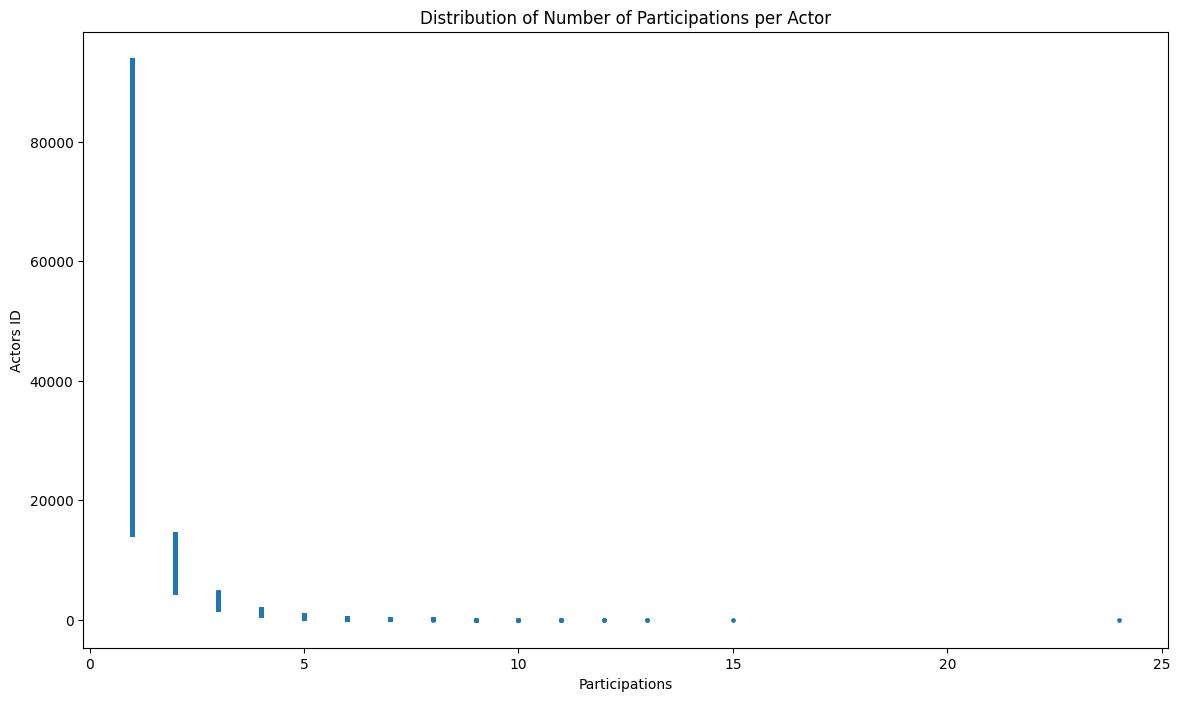

In [239]:
# Give an index for better representation
actor_participations = actors['actor_name'].value_counts().reset_index()
actor_participations.columns = ['actor', 'participations']
print(actor_participations.head(2))

# Configure the plot
plt.figure(figsize=(14, 8))
sns.scatterplot(x='participations', y=actor_participations.index, data=actor_participations, edgecolor=None, s=10)
plt.title('Distribution of Number of Participations per Actor')
plt.xlabel('Participations')
plt.ylabel('Actors ID')
plt.show()


# Final actors preprocessing before sparse matrix

In [240]:
actors['actor_name'] = actors['actor_name'].str.lower().str.strip()

# Create a mapping between actor names and new IDs
actor_to_id = {}
for idx, name in enumerate(actors['actor_name'].unique()):
    actor_to_id[name] = idx

id_to_actor = {}
for name, idx in actor_to_id.items():
    id_to_actor[idx] = name

# Add the 'actor_id' column
actors['actor_id'] = actors['actor_name'].map(actor_to_id)

# Check for duplicate actor names with different IDs
double_ids = actors.groupby('actor_name')['actor_id'].nunique().reset_index()
duplicated_ids = double_ids[double_ids['actor_id'] > 1]
print("Actors with duplicate names and different IDs:")
print(duplicated_ids)

# Map the movie id to a new ID from 0
movieid_to_newid = {}
for idx, movie_id in enumerate(actors['movie_id'].unique()):
    movieid_to_newid[movie_id] = idx

actors['new_movie_id'] = actors['movie_id'].map(movieid_to_newid)

# Randomly shuffle the movie indices
shuffled_movie_indices = np.random.permutation(actors['movie_id'].unique())
movieid_to_newid = {}
for idx, movie_id in enumerate(shuffled_movie_indices):
    movieid_to_newid[movie_id] = idx
actors['new_movie_id'] = actors['movie_id'].map(movieid_to_newid)

newid_to_oldmovie_id = {}
for movie_id, idx in movieid_to_newid.items():
    newid_to_oldmovie_id[idx] = movie_id

print(actors.head(5))

Actors with duplicate names and different IDs:
Empty DataFrame
Columns: [actor_name, actor_id]
Index: []
         movie_id         actor_name  actor_id  new_movie_id
2007526   1130900  bernadette lafont         0         96316
3377872   1308347        ryan eggold         1         63770
32223     1000552       sam robinson         2         52805
2433306   1177225      alyn lockwood         3         73649
3342026   1302421       václav jílek         4          4349


# Sparse Matrix Setup

In [241]:
def createSparseMatrix(rows, columns, data):

    # Initialize empty lists (data,rows,columns)
    data_list = []
    rows_index_list = []
    columns_index_list = []

    # Populating list with data 1 by 1
    for r, c, d in zip(rows, columns, data):
        rows_index_list.append(r)
        columns_index_list.append(c)
        data_list.append(d)

    # Coversion to numpy array for easier use
    data_array = np.array(data_list)
    rows_index_array = np.array(rows_index_list)
    columns_index_array = np.array(columns_index_list)

    # Return the sparse matrix components
    return data_array, rows_index_array, columns_index_array


In [242]:
from scipy.sparse import csr_matrix

# assign params to create the sparse matrix
rows = actors['new_movie_id']   # rows are the new movie id
columns = actors['actor_id']    # columns are the actor's id
# data is an array of 1s (use the actors lenght since at max we have len(actors)1s needed for the matrix)
data = []
for _ in range(len(actors)):
    data.append(1)

# number of rows
n_movies = len(actors['movie_id'].unique())

# number of columns
n_actors = actors['actor_id'].nunique()

# Assign the arrays using the function
data_array, row_indices_array, col_indices_array = createSparseMatrix(rows, columns, data)

# Convert arrays to CSR matrix
utility_matrix_csr = csr_matrix((data_array, (row_indices_array, col_indices_array)), shape=(n_movies, n_actors))

In [243]:
density = utility_matrix_csr.nnz / (n_movies * n_actors)
print(f"Utility Matrix Density: {density:.10f}")

Utility Matrix Density: 0.0000126765


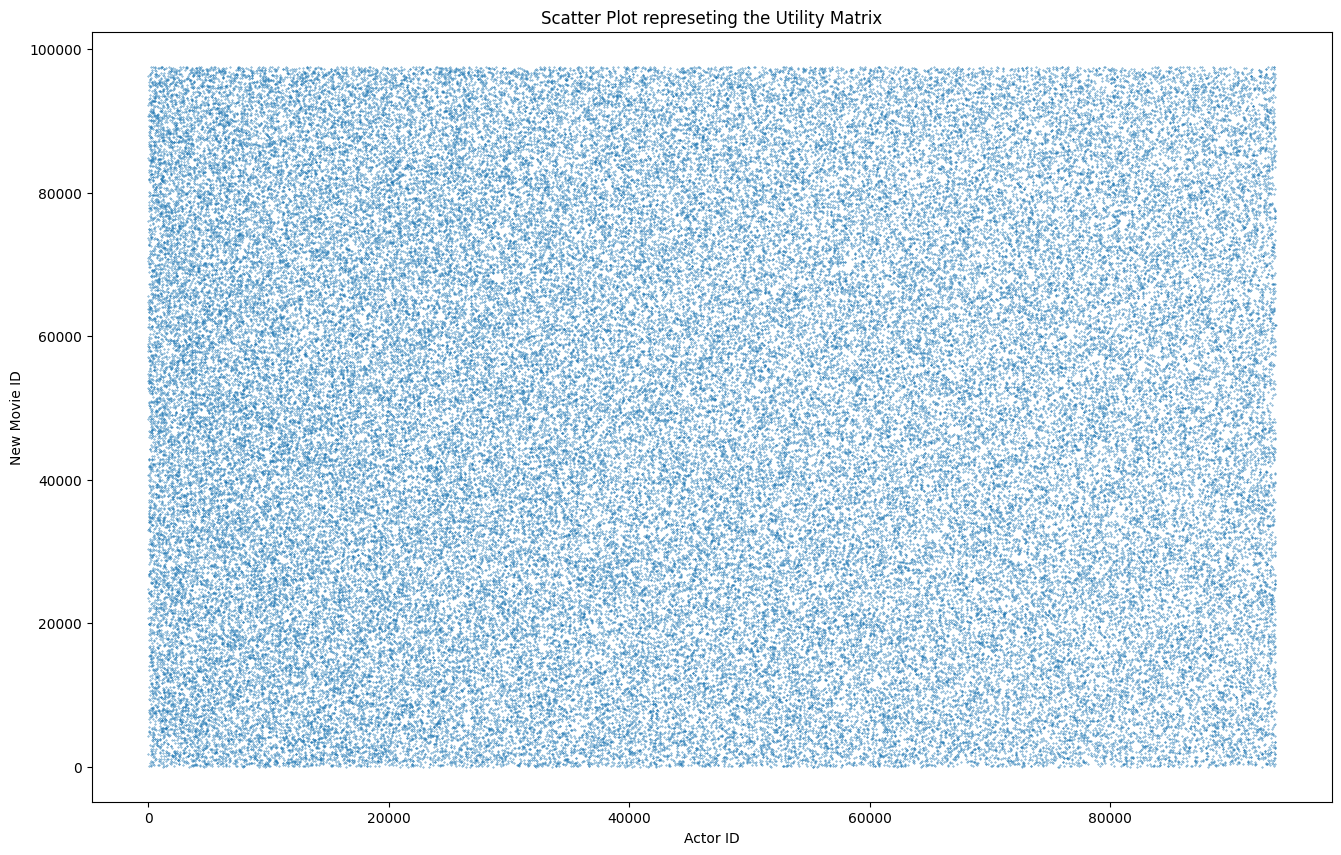

In [244]:
# Get the nonzero values to plot the data
movie__plot_data, actor_plot_data = utility_matrix_csr.nonzero()

plt.figure(figsize=(16, 10))
plt.scatter(actor_plot_data, movie__plot_data, s=0.1)
plt.title('Scatter Plot represeting the Utility Matrix')
plt.xlabel('Actor ID')
plt.ylabel('New Movie ID')
plt.show()


In [245]:
# Calculate similarity matrix for actors
similarity_matrix = cosine_similarity(utility_matrix_csr.T)
print(f"Similarity matrix: {similarity_matrix.shape}")

Similarity matrix: (93756, 93756)


# Recommendation

In [246]:
actors.head()

,movie_id,actor_name,actor_id,new_movie_id
2007526,1130900,bernadette lafont,0,96316
3377872,1308347,ryan eggold,1,63770
32223,1000552,sam robinson,2,52805
2433306,1177225,alyn lockwood,3,73649
3342026,1302421,václav jílek,4,4349


In [247]:
# Function to get some random movies with rating above average
def get_random_good_movies(r_movies, actor_to_avoid = None, avg_rating=2.5, n_movies_sample=5):

    # get the movies with rating above average
    random_good_movies = r_movies[r_movies['movie_rating'] > avg_rating]

    # if there is an actor selected, remove the films in which he partecipated from the list
    if actor_to_avoid is not None:
          movies_to_remove = actors[actors['actor_name'] == actor_to_avoid]['movie_id']
          random_good_movies = random_good_movies[random_good_movies['movie_id'] != movies_to_remove]
          # if there are no more movies left, ignore the actor contraint
          if len(random_good_movies) < 1:
            return get_random_good_movies(r_movies)

    # if the movies are less then the minimum default, set the minimum as the number of movies selected
    if len(random_good_movies) < n_movies_sample:
        return random_good_movies.sample(n=len(random_good_movies))

    # if there are no movies to recommend, include also bad movies
    if(len(random_good_movies) < 1):
        return get_random_good_movies(r_movies, avg_raing=0)

    return random_good_movies.sample(n=n_movies_sample)


In [248]:
def actor_recommend_movies(actor_name, actors_, movies_, utility_matrix_csr, similarity_matrix):

    # Get the actor ID
    id_actor = actor_to_id.get(actor_name)
    if not id_actor:
        raise ValueError(f"Actor {actor_name} not found")

    # Get the movies (id) associated with the actor
    movies_actor = actors_[actors_['actor_id'] == id_actor]['new_movie_id'].values

    # Compute the similarity scores between the actor and all movies
    actor_similarities = similarity_matrix[id_actor, :]     # get all the row of the similarity matrix corresponding to that actor

    movie_similarities = utility_matrix_csr.dot(actor_similarities) # dot product with the utility matrix in order to find similarity

    # Set the similarity of the movies that the actor has been a part of as an absolute negative for the recommendation
    movie_similarities[movies_actor] = -np.inf

    # Find the top 10 more similar movies
    top_movie_indices = np.argpartition(movie_similarities, -10)[-10:]

    # Get the similarity score of those movies
    top_movie_similarities = movie_similarities[top_movie_indices]

    # Order the movies based on the similarity score in descending order
    sorted_top_movie_indices = top_movie_indices[np.argsort(top_movie_similarities)[::-1]]

    # Extract the top 5 of the ordered movies
    top_movie_indices = sorted_top_movie_indices[:5]

    # Initialize an empty list for recommended movies
    recommended_movie_ids = []
    # For each movie in the top 5
    for id_movie_top in top_movie_indices:
        # Find the corresponding record in the actors table
        movie_actor_row = actors_[actors_['new_movie_id'] == id_movie_top]
        # Extract the movie ID
        movie_id_row = movie_actor_row['movie_id'].values[0]
        # Add the movie ID to the recommended list
        recommended_movie_ids.append(movie_id_row)

    # Get details of the recommended movies from the movies DataFrame
    recommended_movies = movies_[movies_['movie_id'].isin(recommended_movie_ids)]

    # Return a DataFrame containing the movie names, ratings, duration, release date, and similarity scores
    return recommended_movies[['movie_name', 'movie_rating', 'movie_minute', 'movie_date']]


In [249]:
def get_recommendations_random(_actors, _movies, utility_matrix_csr, similarity_matrix):

    # Select a random actor ID
    actor_id_random = _actors['actor_id'].sample(n=1).iloc[0]

    # Get the actor name using id_to_actor mapping
    random_actor_name = id_to_actor[actor_id_random]

    #Get the average of the ratings
    average_ratings = movies['movie_rating'].mean()

    try:
        # Try to get recommendations for the selected actor
        recommended_movies = actor_recommend_movies(random_actor_name, _actors, _movies, utility_matrix_csr, similarity_matrix)

        if not recommended_movies.empty:
            print(f"Movies recommended for the actor {random_actor_name}:")
            return recommended_movies
        else:
            #return get_recommendations_random(actors, movies, utility_matrix_csr, similarity_matrix)

            # Get random films above rating if no recommendations available
            print(f"Personal recommendation not possible for {random_actor_name}. Check this good movies:")
            random_movies = get_random_good_movies(_movies, random_actor_name, avg_rating=average_ratings)
            print(random_movies[['movie_name', 'movie_rating', 'movie_minute', 'movie_date']])
            return random_movies

    except ValueError as e:
        print(e)
        # Handle error by suggesting random films
        print("Personal recommendations not possible. Check this good movies:")
        random_movies = get_random_good_movies(_movies, avg_rating=average_ratings)
        print(random_movies[['movie_name', 'movie_rating', 'movie_minute', 'movie_date']])
        return random_movies

In [250]:
# Call the function to find a valid actor and get recommendations
recommendations = get_recommendations_random(actors, movies, utility_matrix_csr, similarity_matrix)
recommendations.head()

Movies recommended for the actor john derek:


,movie_name,movie_rating,movie_minute,movie_date
207539,Sentence of God,3.231117,0.00148,1972
